In [1]:
from glob import glob
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#JetTaggingComparisonFiles = glob(f'/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/JT_val.root')
# single file
JetTaggingComparisonFiles = glob(f'/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/JT_Comparison_.root')
print(JetTaggingComparisonFiles)

tag_names = ['b', 'c', 'uds']
if True:
    n_b = 500
    n_c = 500
else:
    n_b = 4800
    n_c = 5400
    
uf = ur.open(JetTaggingComparisonFiles[0])
t = uf['JetTaggingComparison']

event_nr = np.array(t['event'].array(), dtype=int)
event_nr

tot_length = len(event_nr)

event_splits = np.where(np.abs(np.diff(event_nr, prepend=[event_nr[0]])) > 1)[0]

masks:dict[str, np.ndarray] = {}
for i, name in enumerate(tag_names):
    masks[name] = np.zeros(tot_length, dtype=bool)

masks['b'][:event_splits[0]] = True
masks['c'][event_splits[0]:] = True

# get the tags
tagsPNet_raw = np.array(t['tags1'].array()).squeeze()

tagsLCFI = np.array(t['tags2'].array()).squeeze()
tagsPNet = np.zeros(tagsLCFI.shape)
tagsPNet[:, [0,1,2]] = tagsPNet_raw[:, [0,1,2]]
tagsPNet[:, 2] += tagsPNet_raw[:, 3]

print('pre check', len(tagsPNet), tagsPNet.sum(), tagsLCFI.sum())

# sort out invalid predictions
# some rows in LCFIPlus are zero; TODO: Why?
mask_invalid = tagsLCFI.sum(axis=1) == 0

tagsPNet = tagsPNet[~mask_invalid]
tagsLCFI = tagsLCFI[~mask_invalid]

masks['b'] = masks['b'][~mask_invalid]
masks['c'] = masks['c'][~mask_invalid]

tot_length = len(masks['b'])

predLCFI = np.argmax(tagsLCFI, axis=1)
predPNet = np.argmax(tagsPNet, axis=1)

print('post check', len(tagsPNet), tagsPNet.sum(), tagsLCFI.sum())

y_true = np.zeros(tot_length, dtype=int)

y_true[masks['b']] = 1
y_true[masks['b']] = 0

['/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/JT_Comparison_.root']
pre check 180 179.99999998651788 178.0
post check 178 177.9999998971109 178.0


Multi file

In [2]:
jetTaggingComparisonFiles = glob(f'/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/*.root')
jetTaggingComparisonFiles.sort()
print(jetTaggingComparisonFiles)

['/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_0.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_1.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_10.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_11.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_12.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_13.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_14.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_15.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_16.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTesting/output/AIDAFile_bbbbbb_17.roo

In [3]:
tag_names = ['b', 'c', 'uds']
tag_names

['b', 'c', 'uds']

In [4]:
label_index_transl = {
    'b': 0,
    'c': 1,
    's': 2,
    'd': 2,
    'u': 3
}
def get_label_index(s:str)->int:
    return label_index_transl[s]

def tag_from_path(path:str)->str:
    for name in ['bbbbbb', 'cccccc', 'ssssss', 'uuuuuu', 'dddddd']:
        if f'_{name}_' in path:
            return name[:1]

def get_tot_length(paths:list[str])->int:
    result = 0
    for path in paths:
        with ur.open(path) as rf:
            result += len(rf['JetTaggingComparison']['event'].array())
    
    return result

def parse_file(path:str):
    label:str = tag_from_path(path)
    label_index:int = get_label_index(label)
    
    with ur.open(path) as uf:
        t = uf['JetTaggingComparison']
        
        event_nr = np.array(t['event'].array(), dtype=int)
        
        tot_length = len(event_nr)

        # get the tags
        tagsPNet_raw = np.array(t['tags1'].array()).squeeze()

        tagsLCFI = np.array(t['tags2'].array()).squeeze()
        tagsPNet = np.zeros(tagsLCFI.shape)
        tagsPNet[:, [0,1,2]] = tagsPNet_raw[:, [0,1,2]]
        tagsPNet[:, 2] += tagsPNet_raw[:, 3]
        
        y_true = label_index * np.ones(tot_length)

        #predLCFI = np.argmax(tagsLCFI, axis=1)
        #predPNet = np.argmax(tagsPNet, axis=1)
    
        return tot_length, y_true, tagsPNet, tagsLCFI

In [7]:
tot_length = get_tot_length(jetTaggingComparisonFiles)
pointer = 0

tagsPNet = np.zeros((tot_length, len(tag_names)))
tagsLCFI = np.zeros((tot_length, len(tag_names)))
y_true = np.zeros(tot_length, dtype='B')

for file in jetTaggingComparisonFiles:
    chunk_length, chunk_y_true, chunk_tags_pnet, chunk_tags_lcfi = parse_file(file)
    
    y_true[pointer:pointer+chunk_length] = chunk_y_true
    tagsPNet[pointer:pointer+chunk_length] = chunk_tags_pnet
    tagsLCFI[pointer:pointer+chunk_length] = chunk_tags_lcfi
    
    pointer += chunk_length

y_true = y_true[:pointer]
tagsPNet = tagsPNet[:pointer]
tagsLCFI = tagsLCFI[:pointer]

In [8]:
np.unique(y_true, return_counts=True)

(array([0, 1, 2, 3], dtype=uint8), array([ 578844,  645114, 1318800,  614178]))

0 invalid
15626 invalid
0 invalid
15626 invalid


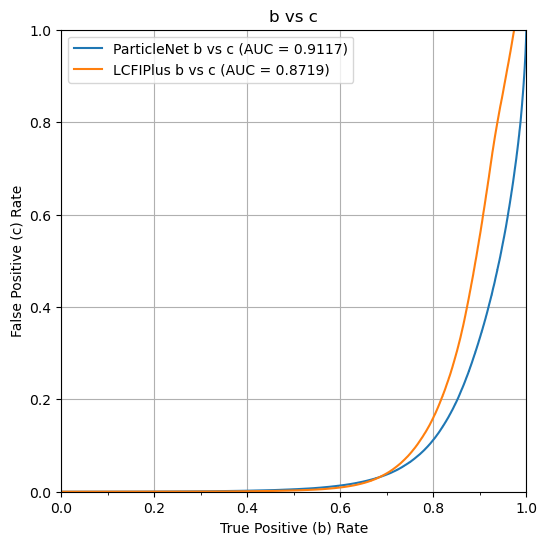

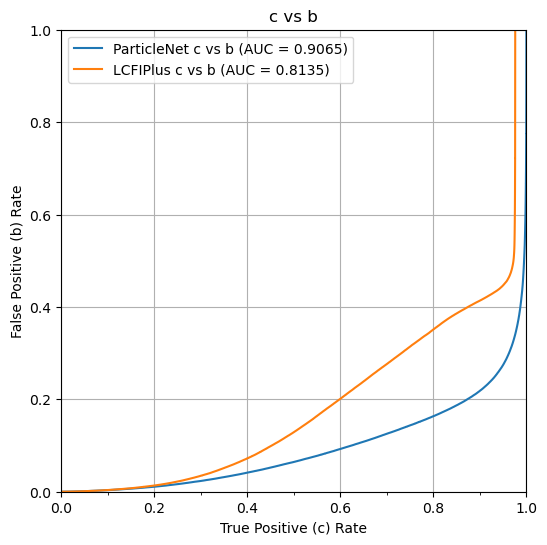

In [9]:
from sklearn import metrics
import matplotlib.ticker as ticker

rocs = {}
for sig_name, bkg_name in [
    ('b', 'c'),
    ('c', 'b')
]:
    sig_index, bkg_index = tag_names.index(sig_name), tag_names.index(bkg_name)
    mask = (y_true == sig_index) | (y_true == bkg_index)

    fig, ax = plt.subplots(figsize=(6, 6))

    for tags, label in [
        (tagsPNet, 'ParticleNet'),
        (tagsLCFI, 'LCFIPlus')
    ]:        
        y_true_subset = np.copy(y_true[mask])
        pred_sig = tags[mask, sig_index]
        
        mask_sig = y_true_subset == sig_index
        mask_bkg = y_true_subset == bkg_index
        y_true_subset[mask_sig] = 1
        y_true_subset[mask_bkg] = 0
        
        # invalid predictions: assume signal, but predicted as background
        mask_invalid = tags[mask].sum(axis=1) == 0
        print(f'{(mask_invalid).sum()} invalid')
        
        y_true_subset[mask_invalid] = 1
        pred_sig[mask_invalid] = 0
        
        # calculate roc curve and plot
        fpr, tpr, threshold = metrics.roc_curve(y_true_subset, pred_sig)
        roc_auc = metrics.auc(fpr, tpr)

        rocs[f'{label}_{sig_name}_vs_{bkg_name}'] = roc_auc
        
        ax.plot(tpr, fpr, label=f'{label} {sig_name} vs {bkg_name} (AUC = {roc_auc:.4f})');
        ax.xaxis.set_minor_locator(ticker.FixedLocator(.1 + np.arange(5)*.2))

    ax.set_xlabel(f'True Positive ({sig_name}) Rate')
    ax.set_ylabel(f'False Positive ({bkg_name}) Rate')
    if True:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    else:
        ax.set_yscale('log')
    ax.set_title(f'{sig_name} vs {bkg_name}')
    ax.grid()
    ax.legend()

In [10]:
np.savez_compressed(f'/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/other/FTag/3_testing/preds_marlin.npz',
    y_true=y_true,
    tagsLCFI=tagsLCFI,
    tagsPNet=tagsPNet
)

In [19]:
(tagsLCFI.sum(axis=1) < 0.1).sum()

75675

In [23]:
mask = tagsLCFI.sum(axis=1) == 0
y_invalid, count_invalid = np.unique(y_true[mask], return_counts=True)

In [30]:
y_invalid

array([0, 1, 2, 3], dtype=uint8)

In [29]:
count_all = np.unique(y_true, return_counts=True)[1]
print(count_invalid/count_all * 100)

[0.80349801 1.7012497  3.12291477 3.07142229]


In [ ]:
(tagsPNet.sum(axis=1) < 0.1).sum()

0

In [105]:
np.unique(y_true_subset, return_counts=True)

(array([0., 1.]), array([574193, 634139]))

(array([147428., 112876.,  87989.,  73747.,  66024.,  61914.,  56725.,
         53809.,  64278., 483542.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

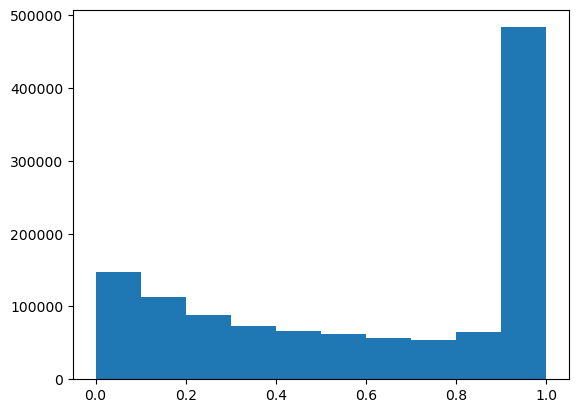

In [106]:
plt.hist(pred_sig)

(array([465670., 140606.,  72739.,  46513.,  33819.,  27445.,  24778.,
         27693.,  40254., 328815.]),
 array([0.00280483, 0.10252279, 0.20224076, 0.30195873, 0.4016767 ,
        0.50139466, 0.60111263, 0.7008306 , 0.80054857, 0.90026654,
        0.9999845 ]),
 <BarContainer object of 10 artists>)

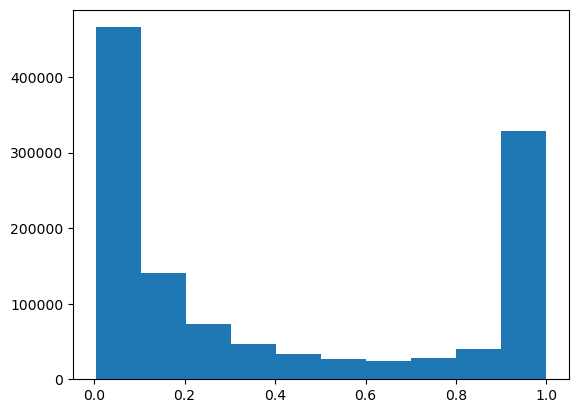

In [101]:
plt.hist(pred_sig)

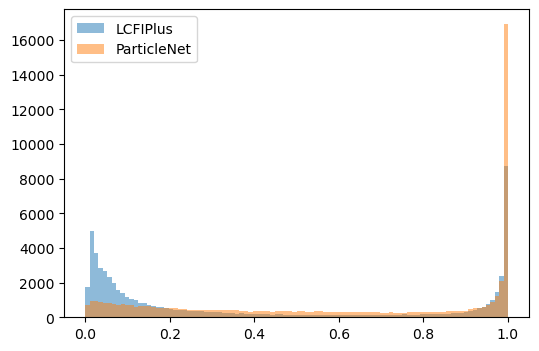

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

for data, label in [
    (bTagLCFI, 'LCFIPlus'), (bTagPNet, 'ParticleNet')
]:
    ax.hist(data, bins=96, label=f'{label}', alpha=0.5);

ax.legend()

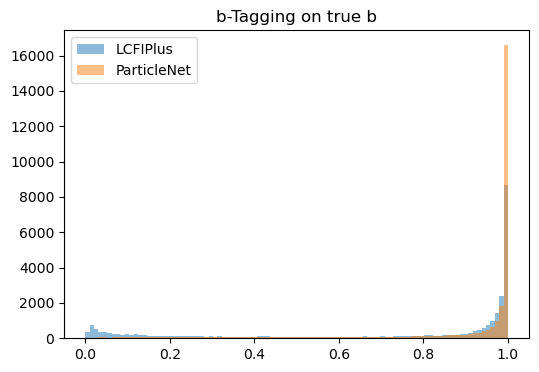

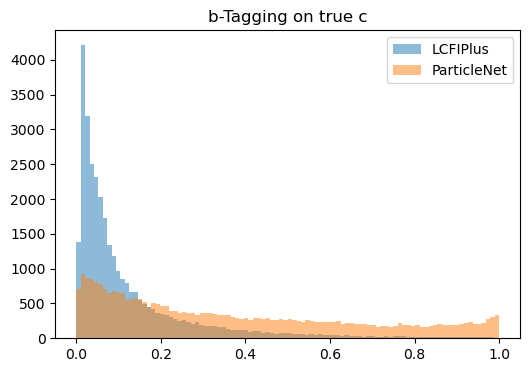

In [26]:
for mask, mask_label in [
    (mask_b, 'true b'), (mask_c, 'true c')
]:
    fig, ax = plt.subplots(figsize=(6, 4))
    
    for data, label in [
        (bTagLCFI, 'LCFIPlus'), (bTagPNet, 'ParticleNet')
    ]:
        ax.hist(data[mask], bins=96, label=f'{label}', alpha=0.5);
    
    ax.set_title(f'b-Tagging on {mask_label}')
    ax.legend()

(array([711., 917., 864., 858., 806., 779., 708., 657., 681., 666., 657.,
        552., 561., 577., 570., 519., 454., 500., 493., 470., 459., 394.,
        394., 370., 381., 368., 361., 340., 361., 358., 360., 343., 331.,
        329., 340., 300., 292., 270., 292., 268., 297., 288., 275., 290.,
        264., 262., 282., 260., 281., 260., 246., 238., 263., 254., 228.,
        233., 229., 233., 233., 247., 210., 213., 226., 200., 210., 206.,
        193., 185., 161., 181., 174., 163., 181., 223., 192., 185., 173.,
        196., 169., 161., 175., 185., 199., 189., 191., 193., 192., 201.,
        224., 231., 206., 212., 214., 270., 308., 334.]),
 array([1.49017738e-04, 1.05638802e-02, 2.09787432e-02, 3.13936062e-02,
        4.18084674e-02, 5.22233285e-02, 6.26381934e-02, 7.30530545e-02,
        8.34679157e-02, 9.38827768e-02, 1.04297638e-01, 1.14712507e-01,
        1.25127360e-01, 1.35542229e-01, 1.45957097e-01, 1.56371951e-01,
        1.66786820e-01, 1.77201673e-01, 1.87616542e-01, 1.9803

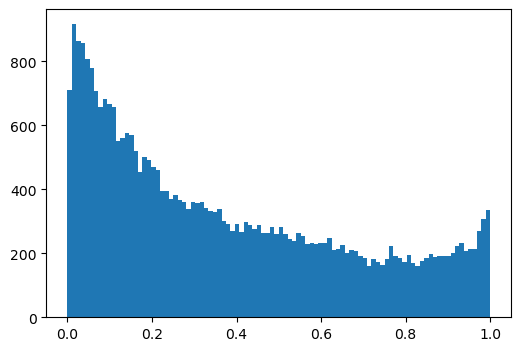

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(bTagPNet[mask_c], bins=96)

In [17]:
bTagPNet.sum(axis=0)

37299.27